In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import XAIChem

In [47]:
smiles_list = ["CC(=O)O", "Nc1ncnc2nc[nH]c12", "CC(=O)Oc1ccccc1C(=O)O"]


for smiles in smiles_list:
    rdmol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(rdmol, returnPNG=True)
    img.save(f"../../thesis/Fig/{smiles}.png")


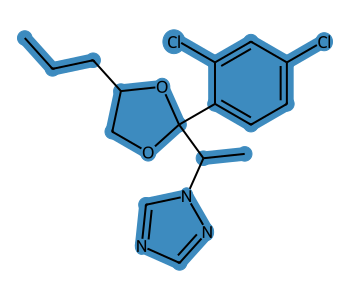

In [42]:
smiles = "CCCC1COC(C(C)n2cncn2)(c2ccc(Cl)cc2Cl)O1"
masks = XAIChem.substructures.BRICSMasks(smiles)
XAIChem.showMolecule(
    Chem.MolFromSmiles(smiles), 
    atoms_highlight_values={atom_ids: 0.75 for atom_ids in masks.atom_ids}
)

# Pipeline molecule

In [2]:
# Load trained models
model, config = XAIChem.models.PreBuildModels.rgcnWuEtAll("../scripts/esol/model_config.yaml", ["seed"], model_id=0)

paths = [
    f"../../data/ESOL/trained_models/rgcn_model_{model_id}_early_stop.pt"
    for model_id in range(10)
]

models = XAIChem.loadModels(model, paths)

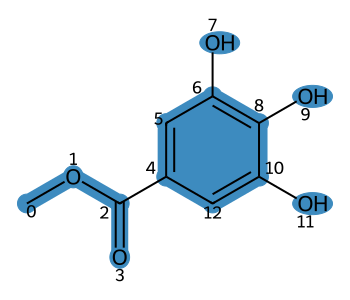

In [14]:
smiles = "COC(=O)c1cc(O)c(O)c(O)c1"

explanation = XAIChem.substructures.functionalGroupMasks(smiles, inverse=True)
XAIChem.showMolecule(
    Chem.MolFromSmiles(smiles), 
    atoms_highlight_values={atom_ids: 0.75 for atom_ids in explanation.atom_ids},
    show_atom_indices=True
)

In [15]:
graph = XAIChem.createDataObjectFromSmiles(smiles, 0)

esol_df = pd.read_csv("../../data/ESOL/ESOL.csv")
experimental_esol = esol_df.query("smiles == @smiles").ESOL.iloc[0]
predicted_esol = np.round(XAIChem.predict(graph, models).item(), 2)

print(f"{experimental_esol = }")
print(f"{predicted_esol = }")

experimental_esol = -1.24
predicted_esol = -1.26


In [18]:
explanation = XAIChem.attribution.substructureMaskExploration(models, explanation, "cpu")
explanation = XAIChem.attribution.hamiacheNavarroValue(models, explanation, -3.126729149389177, shapley=True)

In [19]:
explanation.set_index(["substruct_smiles", "atom_ids"])[["SME", "Shapley_value", "HN_value"]]

SME  Shapley_value  HN_value
substruct_smiles atom_ids                                               
R-C(=O)OCH3      (2, 3, 1, 0)         -0.001424       0.584758  1.690322
ROH              (7,)                  0.474769       0.823800  1.999107
                 (9,)                  0.445053       0.784972  1.970428
                 (11,)                 0.474769       0.823800  1.999107
scaffold         (4, 5, 6, 8, 10, 12) -1.140460      -1.149769 -5.791403

In [25]:
graph

Data(x=[13, 38], edge_index=[2, 26], edge_attr=[26, 10], y=0.0, edge_type=[26, 1], smiles='COC(=O)c1cc(O)c(O)c(O)c1', batch=[1])